[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)

#### based on Fig. 3 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Singer import Settings, Simulation
from PySDM_examples.Singer.aerosol import AerosolBetaCary

from atmos_cloud_sim_uj_utils import show_plot
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from matplotlib import pyplot
import matplotlib
from joblib import Parallel, delayed
import numba

In [3]:
numba.config.NUMBA_NUM_THREADS=2
rtol_x = 1e-3
rtol_thd = 1e-3

In [4]:
CI = 'CI' in os.environ

# updraft_list = np.geomspace(0.1, 5, 2 if CI else 10)
# forg_list = np.linspace(0.2, 0.8, 2 if CI else 10)
updraft_list = np.geomspace(0.1, 5, 2 if CI else 3)
forg_list = np.linspace(0.2, 0.8, 2 if CI else 3)
models = ('bulk', 'Ovad')

In [5]:
def compute(key, settings):
    settings.output_interval = 1*si.s
    settings.rtol_x = rtol_x
    settings.rtol_thd = rtol_thd
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.aerosol_modes_per_cc[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(forg_list) * len(updraft_list)}')
output = dict(Parallel(verbose=10, n_jobs=-2)(
    delayed(compute)("w{:.2f}_f{:.2f}_".format(w,Forg)+model, Settings(
        dt = 0.1*si.s, 
        n_sd_per_mode = 512, 
        model = model,
        aerosol = AerosolBetaCary(Forg=Forg),
        w = w * si.m / si.s,
        spectral_sampling = spec_sampling.ConstantMultiplicity
    ))
    for w in updraft_list
    for Forg in forg_list
    for model in models
))

tasks scheduled: 18


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-2)]: Done   7 out of  18 | elapsed:   44.4s remaining:  1.2min
[Parallel(n_jobs=-2)]: Done   9 out of  18 | elapsed:   56.6s remaining:   56.6s
[Parallel(n_jobs=-2)]: Done  11 out of  18 | elapsed:   57.5s remaining:   36.6s
[Parallel(n_jobs=-2)]: Done  13 out of  18 | elapsed:   59.2s remaining:   22.8s
[Parallel(n_jobs=-2)]: Done  15 out of  18 | elapsed:  1.0min remaining:   12.2s
[Parallel(n_jobs=-2)]: Done  18 out of  18 | elapsed:  1.1min finished


In [6]:
# updraft_list = np.geomspace(0.1, 10, 6)
# forg_list = np.linspace(0.1, 0.9, 6)
# models = ('bulk', 'Ovad')

# output = {}
# for forg in forg_list:
#     for w in updraft_list:
#         aerosol = AerosolBetaCary(Forg=forg)
#         for model in models:
#             key = "w{:.2f}_f{:.2f}_".format(w,forg)+model
#             print(key)
#             settings = Settings(
#                 dt=0.1*si.s, 
#                 n_sd_per_mode=100, 
#                 model=model,
#                 aerosol=aerosol,
#                 w=w,
#                 spectral_sampling=spec_sampling.ConstantMultiplicity
#             )
#             settings.output_interval = 2 * si.s

#             simulation = Simulation(settings)
#             output[key] = simulation.run()
#             output[key]['color'] = aerosol.color
#             if model == "bulk":
#                 output[key]['linestyle'] = '-'
#             elif model == "Ovad":
#                 output[key]['linestyle'] = '--'
#             elif model == "Ruehl":
#                 output[key]['linestyle'] = ':'

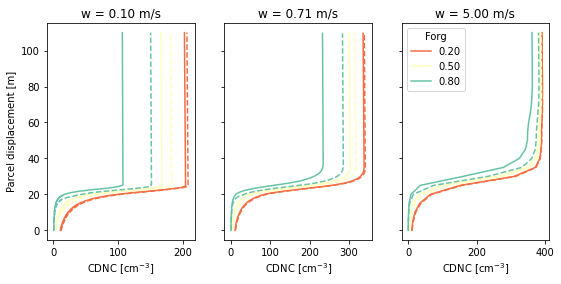

In [7]:
fig,axes = pyplot.subplots(1, len(updraft_list), sharex=False, sharey=True, figsize=(3*len(updraft_list),4))

for i,w in enumerate(updraft_list):
    for j,Forg in enumerate(forg_list):
            key = "w{:.2f}_f{:.2f}_".format(w,Forg)
            var = 'n_c_cm3'
            z = np.array(output[key+"bulk"]['z'])
            CDNC_film = np.array(output[key+"Ovad"][var])
            CDNC_bulk = np.array(output[key+"bulk"][var])

            cmap = matplotlib.cm.get_cmap('Spectral')
            ax = axes[i]

            ax.plot(CDNC_film, z, "--", color=cmap(Forg))
            ax.plot(CDNC_bulk, z, "-", color=cmap(Forg), label="{:.2f}".format(Forg))
            #ax.plot((CDNC_film - CDNC_bulk) / CDNC_bulk * 100, z, "-", color=cmap(Forg), label="{:.2f}".format(Forg))

            if i == 0:
                ax.set_ylabel("Parcel displacement [m]")
            if i == len(updraft_list)-1:
                ax.legend(title="Forg", loc=2)
            ax.set_title("w = {:.2f} m/s".format(w))
            ax.set_xlabel("CDNC [cm$^{-3}$]")

#pyplot.savefig("fig3-parcel-profiles.png",dpi=200)
pyplot.show()

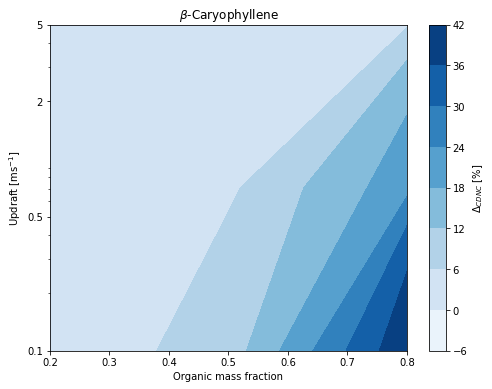

In [8]:
fig, axes = pyplot.subplots(1,1, sharex=True, sharey=True, figsize=(8,6))

dCDNC = np.zeros((len(updraft_list), len(forg_list)))
for i,w in enumerate(updraft_list):
    for j,Forg in enumerate(forg_list):
        key = "w{:.2f}_f{:.2f}_".format(w,Forg)
        var = 'n_c_cm3'
        z = np.array(output[key+"bulk"]['z'])
        wz = np.where(z == z[-1])[0][0]
        CDNC_film = np.array(output[key+"Ovad"][var])[wz]
        CDNC_bulk = np.array(output[key+"bulk"][var])[wz]
        dCDNC[i,j] = (CDNC_film - CDNC_bulk) / CDNC_bulk * 100.0
        #print(w, Forg, CDNC_bulk, CDNC_film, dCDNC[i,j])

ax = axes
ax.set_title("$\\beta$-Caryophyllene")
#ax.contour(forg_list, updraft_list, dCDNC, levels=[10,25], colors=["#1fa8f2","#4287f5"], linestyles=[":","--"], linewidths=4)

#levs = np.linspace(0,90,11)
levs = 7
p = ax.contourf(forg_list, updraft_list, dCDNC, cmap="Blues", levels=levs)

dat = np.zeros((len(forg_list)+1, len(updraft_list)+1))
dat[1:,0] = updraft_list
dat[0,1:] = forg_list
dat[1:,1:] = dCDNC
# print(dat)
# np.savetxt("Ryan_parcel_2D.csv", dat, fmt="%.4f", delimiter=',', header="W (m/s) (left col), Forg (top row), delta CDNC (%) (grid below), -, -, -, -, -, -, -, -") 
           #comments='Forg fractions in first row // Updraft speed in first column // dCDNC in grid\n')

ax.set_xlabel("Organic mass fraction")
ax.set_yscale("log")
ax.set_yticks([0.1,0.5,2,5])
ax.set_yticklabels(["0.1","0.5","2","5"])
ax.set_ylabel("Updraft [ms$^{-1}$]")
pyplot.colorbar(p, ax=ax, label="$\Delta_{CDNC}$ [%]")

pyplot.rcParams.update({'font.size': 15})
#pyplot.savefig("bCary_dCDNC_OVF_Updraft.png", dpi=200)
pyplot.show()
#show_plot()

In [8]:
# fig,axes = pyplot.subplots(2,2,figsize=(10,10),sharex=True,sharey=False)

# f0 = open("PySDM_Marine_0_0org.txt","w")
# f1 = open("PySDM_Marine_1_0org.txt","w")

# f0.write("parcel disp = 200.00 \n")
# f0.write("updraft (m/s), forg, CDNC (cm-3) \n")
# f1.write("parcel disp = 200.00 \n")
# f1.write("updraft (m/s), forg, CDNC (cm-3) \n")

# for k,subplot in enumerate(subplot_list):
#     for i,w in enumerate(updraft_list):
#         for j,Forg in enumerate(forg_list):
#                 key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
#                 var = 'n_c_cm3'
#                 z = np.array(output[key+"film"]['z'])
#                 CDNC_film = np.array(output[key+"film"][var])
#                 CDNC_bulk = np.array(output[key+"bulk"][var])
                
#                 ax = axes.flatten()[k]
#                 ax.set_title(subplot, loc="left", weight="bold")
                
#                 cmap = matplotlib.cm.get_cmap('Spectral')
#                 if i == 0:
#                     ax.plot(w, CDNC_bulk[-1], 'o', color=cmap(Forg), label="{:.2f}".format(Forg))
#                     ax.plot(w, CDNC_film[-1], '*', color=cmap(Forg))
#                 else:
#                     ax.plot(w, CDNC_bulk[-1], 'o', color=cmap(Forg))
#                     ax.plot(w, CDNC_film[-1], '*', color=cmap(Forg))
                
#                 if subplot == "b":
#                     f0.write("{:.2e}, {:.2f}, {:.2f} \n".format(w, Forg, CDNC_bulk[-1]))
#                     f1.write("{:.2e}, {:.2f}, {:.2f} \n".format(w, Forg, CDNC_film[-1]))
                
#                 ax.set_xscale("log")
#                 if k == 0:
#                     ax.legend(title="Forg")
#                     ax.set_ylabel("CNDC [cm$^{-3}$]")
#                 if k == 2:
#                     ax.set_ylabel("CNDC [cm$^{-3}$]")
#                 if k > 1:
#                     ax.set_xlabel("updraft velocity [m/s]")
                
# #pyplot.savefig("fig3-parcel-profiles.png",dpi=200)
# pyplot.show()

# f0.close()
# f1.close()

# #########################

# fig,axes = pyplot.subplots(2,2,figsize=(10,10),sharex=True,sharey=False)

# for k,subplot in enumerate(subplot_list):
#     for i,w in enumerate(updraft_list):
#         for j,Forg in enumerate(forg_list):
#                 key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
#                 var = 'n_c_cm3'
#                 z = np.array(output[key+"film"]['z'])
#                 CDNC_film = np.array(output[key+"film"][var])
#                 CDNC_bulk = np.array(output[key+"bulk"][var])
                
#                 ax = axes.flatten()[k]
#                 ax.set_title(subplot, loc="left", weight="bold")
                
#                 cmap = matplotlib.cm.get_cmap('Spectral')
#                 if i == 0:
#                     ax.plot(w, CDNC_film[-1] - CDNC_bulk[-1], 'o', color=cmap(Forg), label="{:.2f}".format(Forg))
#                 else:
#                     ax.plot(w, CDNC_film[-1] - CDNC_bulk[-1], 'o', color=cmap(Forg))
                
#                 ax.set_xscale("log")
#                 if k == 0:
#                     ax.legend(title="Forg")
#                     ax.set_ylabel("$\Delta$CNDC [cm$^{-3}$]")
#                 if k == 2:
#                     ax.set_ylabel("$\Delta$CNDC [cm$^{-3}$]")
#                 if k > 1:
#                     ax.set_xlabel("updraft velocity [m/s]")
                
# #pyplot.savefig("fig3-parcel-profiles.png",dpi=200)
# pyplot.show()

# #########################

# fig,axes = pyplot.subplots(2,2,figsize=(10,10),sharex=True,sharey=False)

# for k,subplot in enumerate(subplot_list):
#     for i,w in enumerate(updraft_list):
#         for j,Forg in enumerate(forg_list):
#                 key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
#                 var = 'n_c_cm3'
#                 z = np.array(output[key+"film"]['z'])
#                 CDNC_film = np.array(output[key+"film"][var])
#                 CDNC_bulk = np.array(output[key+"bulk"][var])
                
#                 ax = axes.flatten()[k]
#                 ax.set_title(subplot, loc="left", weight="bold")
                
#                 cmap = matplotlib.cm.get_cmap('Spectral')
#                 if i == 0:
#                     ax.plot(w, (CDNC_film[-1] - CDNC_bulk[-1]) / CDNC_bulk[-1] * 100.0, 'o', color=cmap(Forg), label="{:.2f}".format(Forg))
#                 else:
#                     ax.plot(w, (CDNC_film[-1] - CDNC_bulk[-1]) / CDNC_bulk[-1] * 100.0, 'o', color=cmap(Forg))
                
#                 ax.set_xscale("log")
#                 if k == 0:
#                     ax.legend(title="Forg")
#                     ax.set_ylabel("$\Delta$CNDC [%]")
#                 if k == 2:
#                     ax.set_ylabel("$\Delta$CNDC [%]")
#                 if k > 1:
#                     ax.set_xlabel("updraft velocity [m/s]")
                
# #pyplot.savefig("fig3-parcel-profiles.png",dpi=200)
# pyplot.show()